In [1]:
%matplotlib inline
import pathlib
import io
import re
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 1 Exploratory Data Analysis
## Are first babies born late?

## 1.2 NSFG Data

Using the 2011-13 data because why not (book uses older data). I compressed the `.dat` files to save some space (only because they can be transparently expanded by Pandas when reading)

* [2011-2013 NSFG: Public Use Data Files, Codebooks, and Documentation](http://www.cdc.gov/nchs/nsfg/nsfg_2011_2013_puf.htm)

In [2]:
nsfgdir = pathlib.Path('data/nsfg')
for child in nsfgdir.iterdir():
    print(child)

data\nsfg\DATA_USER_AGREEMENT.md
data\nsfg\2011_2013_FemPregSetup.dct
data\nsfg\2011_2013_FemPregSetup.do
data\nsfg\2011_2013_FemRespSetup.dct
data\nsfg\2011_2013_FemRespSetup.do
data\nsfg\2011_2013_FemRespData.dat.bz2
data\nsfg\2011_2013_FemPregData.dat.bz2


## 1.3 Importing the Data

It looks like some hybrid mix of STATA formats? STATA files are binary, but these have multiple parts:

* `.dat` with data in fixed width columns
* `.dct` a file (that says it's for STATA) that specifies the column widths and what data they contain
* `.do` files with annotations for special values present in the columns

The author also uses some asinine naming scheme unlike anything else, so forget about his code.

In [3]:
def read_stata_data(dat_path: pathlib.Path, dct_spec: pathlib.Path) -> (pd.DataFrame, dict):
    """Reads fixed-width data file as per definitions in STATA .dct file"""
    fwf_kwargs, more_info = read_stata_dct(dct_spec)
    
    fwf_kwargs['compression'] = {'.bz2': 'bz2', '.gz': 'gzip'}.get(dat_path.suffix, None)
    df = pd.io.parsers.read_fwf(str(dat_path), **fwf_kwargs)
    
    return df, more_info

def read_stata_dct(path: pathlib.Path) -> (dict, dict):
    """Determines a STATA .dct file's data definitions"""
    dtype_mapping = {
        'long': int,
        'int': int,
        'byte': int,
        'double': float,
        'float': float,
    }
    
    with path.open() as f:
        colspecs = []
        names = []
        dtypes = {}
        more = {}
        
        col_pattern = re.compile(r'''\s+
            _column\((?P<colstart>\d+)\)\s+
            (?P<dtype>\w+)\s+
            (?P<field>\w+)\s+
            %(?P<width>\d+)(?P<fmtchr>\w)\s+
            (\"(?P<desc>[^\"]*)\")?''',
            flags=re.VERBOSE)
                
        col_defs = (m for m in (col_pattern.match(line) for line in f) if m)
        for col_def in col_defs:
            data = col_def.groupdict()
            
            name = data['field']
            names.append(name)
            
            start = int(data['colstart']) - 1
            width = int(data['width'])
            
            colspecs.append((start, start + width))
            
            if data['fmtchr'] == 'f':
                dtypes[name] = dtype_mapping[data['dtype']]
            elif data['fmtchr'] == 's':
                dtypes[name] = 'str'
        
            more[name] = {'desc': data['desc']}
        
    fwf_kwargs = {
        'colspecs': colspecs,
        'names': names,
        #'converters': dtypes,
    }
        
    return fwf_kwargs, more

In [4]:
pdata = nsfgdir / '2011_2013_FemPregData.dat.bz2'
pspec = nsfgdir / '2011_2013_FemPregSetup.dct'
fempreg, fempreg_info = read_stata_data(pdata, pspec)

pdata = nsfgdir / '2011_2013_FemRespData.dat.bz2'
pspec = nsfgdir / '2011_2013_FemRespSetup.dct'
femresp, femresp_info = read_stata_data(pdata, pspec)

## 1.4 Data Frames

In [5]:
print(type(fempreg))
print(fempreg.shape)

<class 'pandas.core.frame.DataFrame'>
(9543, 278)


## 1.5 Variables

Some of the columns are "recodes", transformations on the raw data that have already been done.

In [6]:
fempreg.columns

Index(['CASEID', 'PREGORDR', 'HOWPREG_N', 'HOWPREG_P', 'MOSCURRP', 'NOWPRGDK', 'PREGEND1', 'PREGEND2', 'HOWENDDK', 'NBRNALIV', 'MULTBRTH', 'BORNALIV', 'DATPRGEN_M', 'DATPRGEN_Y', 'CMOTPREG', 'AGEATEND', 'HPAGEEND', 'GESTASUN_M', 'GESTASUN_W', 'WKSGEST', 'MOSGEST', 'DK1GEST', 'DK2GEST', 'DK3GEST', 'BPA_BDSCHECK1', 'BABYSEX1', 'BIRTHWGT_LB1', 'BIRTHWGT_OZ1', 'LOBTHWGT1', 'BABYSEX2', 'BIRTHWGT_LB2', 'BIRTHWGT_OZ2', 'LOBTHWGT2', 'BABYSEX3', 'BIRTHWGT_LB3', 'BIRTHWGT_OZ3', 'LOBTHWGT3', 'BABYDOB_M', 'BABYDOB_Y', 'CMBABDOB', 'KIDAGE', 'HPAGELB', 'BIRTHPLC', 'PAYBIRTH1', 'PAYBIRTH2', 'PAYBIRTH3', 'CSECPRIM', 'CSECMED1', 'CSECMED2', 'CSECMED3', 'CSECMED4', 'CSECMED5', 'CSECMED6', 'CSECPLAN', 'KNEWPREG', 'TRIMESTR', 'LTRIMEST', 'PRIORSMK', 'POSTSMKS', 'NPOSTSMK', 'GETPRENA', 'BGNPRENA', 'PNCTRIM', 'LPNCTRI', 'LIVEHERE1', 'ALIVENOW1', 'WHENDIED_M1', 'WHENDIED_Y1', 'CMKIDIED1', 'WHENLEFT_M1', 'WHENLEFT_Y1', 'CMKIDLFT1', 'LASTAGE1', 'WHERENOW1', 'LEGAGREE1', 'PARENEND1', 'ANYNURSE1', 'FEDSOLID1', '

## 1.6 Transformation & Cleaning

Some of the fields are numeric even though they represent non-quantative data ("Didn't Respond" &rarr; 98, "Refused" &rarr; 99, etc.). Blindly doing math on such fields is obviously a Bad Thing&trade;

In [7]:
def clean_fempreg(df):
    # ages are in centiyears
    df.AGEPREG /= 100 
    
    # birthweights of 97-99 aren't real
    na_vals = [97, 98, 99]
    for i in ['1', '2', '3']:
        df['BIRTHWGT_LB' + i].replace(na_vals, np.nan, inplace=True)
        df['BIRTHWGT_OZ' + i].replace(na_vals, np.nan, inplace=True)
       
        # birthweights are split into lbs/oz
        df['BIRTHWGT'+ i] = df['BIRTHWGT_LB'+ i] + df['BIRTHWGT_OZ'+ i] / 16
        
clean_fempreg(fempreg)

## 1.7 Validation

The data can sometimes be validated against provided summary statistics. The [Online Codebook page about OUTCOME][outcomedata] says:

    value  label               Total
    1      LIVE BIRTH           6670
    2      INDUCED ABORTION      993
    3      STILLBIRTH             71
    4      MISCARRIAGE          1451
    5      ECTOPIC PREGNANCY     120
    6      CURRENT PREGNANCY     238
           Total                9543

[outcomedata]: http://www.icpsr.umich.edu/icpsradmin/nsfg/variable/613585?studyNumber=9998&vg=7180

In [8]:
fempreg.OUTCOME.value_counts().sort_index()

1    6670
2     993
3      71
4    1451
5     120
6     238
dtype: int64

## 1.8 Interpretation

In [9]:
def casemap(df):
    d = collections.defaultdict(list)
    for index, caseid in df.CASEID.iteritems():
        d[caseid].append(index)
    return d

pregcasemap = casemap(fempreg)

In [10]:
cases = pregcasemap[57354]
fempreg.iloc[cases].AGECON

6755    1958
6756    2283
6757    2500
6758    2583
6759    3133
Name: AGECON, dtype: int64

## 1.9 Exercises

In [11]:
first = fempreg[(fempreg.PREGORDR == 1) & (fempreg.OUTCOME == 1)]
second = fempreg[(fempreg.PREGORDR == 2) & (fempreg.OUTCOME == 1)]

In [12]:
first_gestation_weeks = first.WKSGEST.dropna()
second_gestation_weeks = second.WKSGEST.dropna()

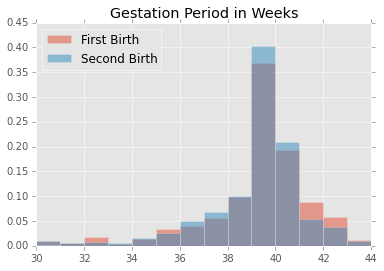

In [13]:
f, ax = plt.subplots()
bins = np.arange(30, 45)
ax.hist(first_gestation_weeks.values, bins=bins, normed=True, alpha=0.5, label='First Birth')
ax.hist(second_gestation_weeks.values, bins=bins, normed=True, alpha=0.5, label='Second Birth')
ax.set_title('Gestation Period in Weeks')
ax.legend(loc='upper left')
pass